<a href="https://colab.research.google.com/github/abhi-lejon/Machine-learning/blob/master/SVM_detailed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.colors import ListedColormap
from mpl_toolkits import mplot3d
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [43]:
matplotlib_axes_logger.setLevel('ERROR')

In [44]:
zero_one_colourmap=ListedColormap(('red','green'))

In [45]:
df=pd.read_csv('/content/train_LZdllcl.csv')

In [46]:
df.shape

(54808, 14)

In [47]:
df.drop(['employee_id','region'],axis=1,inplace=True)

In [48]:
df.head(2)

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,Bachelor's,m,other,1,30,5.0,4,0,0,60,0


The total records corresponding to class Zero are : 50140
The total records corresponding to class Ones are : 4668


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


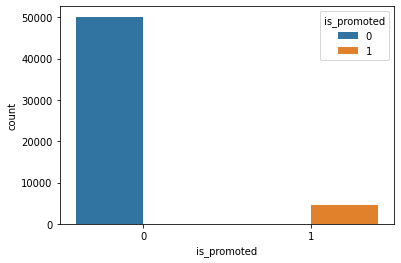

In [49]:
#Foremost important thing is to check the classes in Target column
target='is_promoted'
print('The total records corresponding to class Zero are :',len(df[df[target]==0]))
print('The total records corresponding to class Ones are :',len(df[df[target]==1]))
sns.countplot(df[target],hue=df[target])
#As we see it is completely imbalanced dataset.

In [50]:
#Two ways to treat the imbalanced dataste, 1) Undersampling 2) Oversmapling 
#In undersampling we bring down the no of records equal to minority classes.
#In Oversampling the minority class count is made equal to majority classes.
#In undersampling there will be loss of information, so will go for oversampling.
majority_class=len(df[df[target]==0])
print('The majority class records are',majority_class)
minority_class_indicies=df[df[target]==1].index
print(minority_class_indicies)

The majority class records are 50140
Int64Index([   11,    39,    60,    66,    67,    69,    71,    75,    79,
               84,
            ...
            54695, 54713, 54720, 54722, 54730, 54734, 54757, 54761, 54792,
            54796],
           dtype='int64', length=4668)


In [51]:
minority_indicies=np.random.choice(minority_class_indicies,majority_class)
print(len(minority_indicies))
print(majority_class)

50140
50140


In [52]:
majority_class_indicies=df[df[target]==0].index

In [53]:
over_sampled_data=np.concatenate(([minority_indicies,majority_class_indicies])) #Arrays should be kept always in paranthesis)
df=df.loc[over_sampled_data]

In [54]:
df.shape

(100280, 12)

In [55]:
##Before startring off actual building, lets see how the data fts to perform SVM.

In [56]:
def plot_decision_boundary(X, y, clf):
  X_set, y_set = X, y
  X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, 
                                 stop = X_set[:, 0].max() + 1, 
                                 step = 0.01),
                       np.arange(start = X_set[:, 1].min() - 1, 
                                 stop = X_set[:, 1].max() + 1, 
                                 step = 0.01))
  
  plt.contourf(X1, X2, clf.predict(np.array([X1.ravel(), 
                                             X2.ravel()]).T).reshape(X1.shape),
               alpha = 0.75, 
               cmap = zero_one_colourmap)
  plt.xlim(X1.min(), X1.max())
  plt.ylim(X2.min(), X2.max())
  for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = (zero_one_colourmap)(i), label = j)
  plt.title('SVM Decision Boundary')
  plt.xlabel('X1')
  plt.ylabel('X2')
  plt.legend()
  return plt.show()

In [57]:

def plot_3d_plot(X, y):
  r = np.exp(-(X ** 2).sum(1))
  ax = plt.subplot(projection='3d')
  ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=100, cmap=zero_one_colourmap)
  ax.set_xlabel('X1')
  ax.set_ylabel('X2')
  ax.set_zlabel('y')
  return ax

In [58]:
#Finding Missing values
def nullvalue(df):
    df=df.mask(df==0,0.0001)
    nullvaluecolumns=df.isna().sum()/df.shape[0]*100
    print('The total columns are :',len(nullvaluecolumns))
    drop_cols=nullvaluecolumns[nullvaluecolumns>30]
    print('The columns to be dropped are :', len(drop_cols))
    print(drop_cols)
    df.drop(df[drop_cols],axis=1,inplace=True)
    retained_cols=nullvaluecolumns[nullvaluecolumns<30]
    print('The columns to be retained are :', len(retained_cols))
    print('The retained columns are',retained_cols)
    features_with_nan=[feature for feature in df.columns if df[feature].isna().sum()>=1]
    print('The columns containing Nan values are :',len(features_with_nan))
    print('features_with_nan',features_with_nan)
    features_with_nan_cat=[feature for feature in df.columns if df[feature].isna().sum()>=1 and df[feature].dtypes=='O']
    print('The categorical columns with missing values are',features_with_nan_cat)
    features_with_nan_num=[feature for feature in df.columns if df[feature].isna().sum()>=1 and df[feature].dtypes!='O']
    print('The Numerical columns with missing values are',features_with_nan_num)
    Numerical=[feature for feature in df.columns if df[feature].dtypes!='O']
    print('The Numerical columns are :',Numerical)
    Categorical=[feature for feature in df.columns if df[feature].dtypes=='O']
    print('The Categorical columns are :',Categorical)
    year_feature=[feature for feature in Numerical if 'Yr' in feature or 'Year' in feature]
    print('The year columns are',len(year_feature))
    #Lets print the discrete and continous features in Numerical columns
    Discrete_Numerical=[feature for feature in Numerical if len(df[feature].unique()<25) and feature not in year_feature]
    print('The discrete numerical features are :', len(Discrete_Numerical))
    print('Discrete_Numerical :',Discrete_Numerical)
    Continous_Numerical=[feature for feature in Numerical if feature not in year_feature+Discrete_Numerical]
    print('The continous numerical features are :', len(Continous_Numerical))
    print('Continous_Numerical :',Continous_Numerical)
    return df,drop_cols,retained_cols,features_with_nan,features_with_nan_cat,features_with_nan_num,Numerical,Categorical,year_feature,Discrete_Numerical,Continous_Numerical
                         

In [59]:
df,drop_cols,retained_cols,features_with_nan,features_with_nan_cat,features_with_nan_num,Numerical,Categorical,year_feature,Discrete_Numerical,Continous_Numerical=nullvalue(df)

The total columns are : 12
The columns to be dropped are : 0
Series([], dtype: float64)
The columns to be retained are : 12
The retained columns are department              0.000000
education               3.573993
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
previous_year_rating    7.319505
length_of_service       0.000000
KPIs_met >80%           0.000000
awards_won?             0.000000
avg_training_score      0.000000
is_promoted             0.000000
dtype: float64
The columns containing Nan values are : 2
features_with_nan ['education', 'previous_year_rating']
The categorical columns with missing values are ['education']
The Numerical columns with missing values are ['previous_year_rating']
The Numerical columns are : ['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'KPIs_met >80%', 'awards_won?', 'avg_training_score', 'is_promoted']
The Categorical columns are : ['departme

In [60]:
#Replace the missing values in eduaction column with most repeated category in the column.
def replacemissingcat(df,features_with_nan_cat):
    for feature in features_with_nan_cat:
        df[feature].fillna(df[feature].value_counts().index[0],inplace=True)
    return df

df=replacemissingcat(df,features_with_nan_cat)

In [61]:
#Lets replace the missing value sin numerical with median.
def replacenummissing(df,features_with_nan_num):
    for feature in features_with_nan_num:
        data=df.copy()
        data[feature].fillna(data[feature].median(),inplace=True)
    return data
df=replacenummissing(df,features_with_nan_num)

In [62]:
#Lets remove outliers
def outliertreatment(df):
    for feature in df.describe().columns:
        Q1=df.describe().at['25%',feature]
        Q3=df.describe().at['75%',feature]
        IQR=Q3-Q1
        UTV=Q3+1.5*IQR
        LTV=Q1-1.5*IQR
        x=np.array(df[feature])
        p=[]
        for j in x:
            if j<LTV or j>UTV:
                p.append(df[feature].median())
            else:
                p.append(j)
        df[feature]=p

In [63]:
outliertreatment(df)

In [64]:
##Feature extraction-Label encoding
Department={'Sales & Marketing':0,'Technology':1,'Procurement':2,'Operations':3,'Analytics':4,'R&D':5,'HR':6,'Finance':7,'Legal':8}
df['department']=df['department'].map(Department)

In [65]:
df=pd.get_dummies(df,columns=['education','gender','recruitment_channel'],drop_first=True)#Ues this method

In [66]:
##Feature Scaling
ss=StandardScaler()
df=pd.DataFrame(ss.fit_transform(df),columns=df.columns)

In [67]:
target='is_promoted'
x=df.loc[:,df.columns!=target]
y=df.loc[:,df.columns==target]

In [68]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=pd.DataFrame(le.fit_transform(y),columns=['is_promoted'])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [69]:
X=x[['avg_training_score','age','KPIs_met >80%','length_of_service','department','previous_year_rating']]

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, 
                                                    random_state = 0)

Lets use both Logistic regression and SVM

In [71]:
from sklearn.linear_model import LogisticRegression
LR=LogisticRegression()
LR.fit(X_train,y_train)
y_pred=LR.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [72]:
def generatemodelreport(y_actual,y_predicted):
    print("Accuracy = ",accuracy_score(y_test,y_pred))
    #print("Precision = ",precision_score(y_test,y_pred))
    #print("Recal = ",recall_score(y_test,y_pred))
    #print("F1 score = ",f1_score(y_test,y_pred))
    pass

In [73]:
generatemodelreport(y_test,y_pred)

Accuracy =  0.7159154367770243


In [74]:
def generate_auc_roc_curve(LR,x_test):
    y_pred_proba=LR.predict_proba(x_test)[:,1]
    print(y_pred_proba.shape)
    fpr,tpr,thresholds=roc_curve(y_test,y_pred_proba)
    auc=roc_auc_score(y_test,y_pred_proba)
    plt.plot(fpr,tpr,label='AUC ROC crve with area under the curve='+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

(25070,)


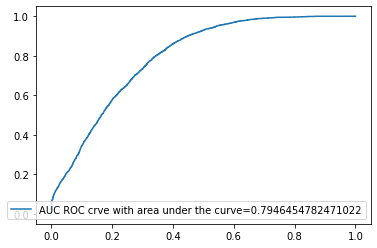

In [75]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,confusion_matrix,classification_report
generate_auc_roc_curve(LR,X_test)

In [76]:
from sklearn.svm import SVC

In [77]:
print(X_train.shape),print(X_test.shape),print(y_train.shape),print(y_test.shape)

(75210, 6)
(25070, 6)
(75210, 1)
(25070, 1)


(None, None, None, None)

In [78]:
svc=SVC(C=1,kernel='linear')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [79]:
def generatemodelreport(y_actual,y_predicted):
    print("Accuracy = ",accuracy_score(y_test,y_pred))
    print("Precision = ",precision_score(y_test,y_pred))
    print("Recal = ",recall_score(y_test,y_pred))
    print("F1 score = ",f1_score(y_test,y_pred))
    pass

In [80]:
generatemodelreport(y_test,y_pred)

Accuracy =  0.6940566414040686
Precision =  0.6852068240243048
Recal =  0.7079275653923541
F1 score =  0.6963819175045524


In [81]:
def generate_auc_roc_curve(LR,x_test):
    y_pred_proba=LR.predict_proba(x_test)[:,1]
    print(y_pred_proba.shape)
    fpr,tpr,thresholds=roc_curve(y_test,y_pred_proba)
    auc=roc_auc_score(y_test,y_pred_proba)
    plt.plot(fpr,tpr,label='AUC ROC crve with area under the curve='+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

(25070,)


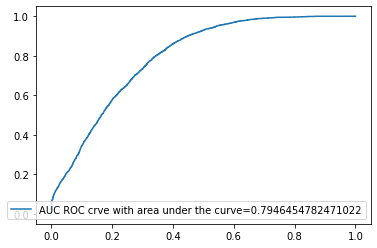

In [82]:
generate_auc_roc_curve(LR,X_test)

In [83]:
cm=confusion_matrix(y_test,y_pred)
cm

array([[8604, 4041],
       [3629, 8796]])

In [84]:
def generate_clf(input_gamma,input_C=1):
  classifier=SVC(kernel='poly',gamma=input_gamma,C=input_C)
  classifier.fit(X,y)
  y_pred=classifier.predict(X)
  print('The training accuracy = {}'.format(accuracy_score(y,y_pred)))
  return classifier

In [85]:
#Classifier_1=generate_clf(0.001)

In [86]:
#Classifier_2=generate_clf(0.01)

In [87]:
#Classifier_3=generate_clf(0.1)

In [88]:
#Classifier_4=generate_clf(1)

In [89]:
Classifier_5=generate_clf(0.1,0.1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The training accuracy = 0.7429397686477862


In [90]:
Classifier_6=generate_clf(0.1,1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The training accuracy = 0.7417530913442362


In [ ]:
Classifier_6=generate_clf(1,10)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [91]:
#In SVM only optimal C and Gamma as to be choosen. Otherwise it fits the model.